<a href="https://colab.research.google.com/github/EytanTsytkin/DataScienceShorts/blob/main/EthereumUsers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, lars_path


pd.options.mode.chained_assignment = None
sns.set_style("whitegrid")

# **Overview and Feature Extraction**

# **Ethereum Useres Dataset**
Each data point is the behavioral distance of two Ethereum users. The behavioral features were determined beforehand. The target of thie exercise it to see wheter users retain their behavior - some of the data points came from the same user (label=1), others didn't. If a classifier can distinguish between the two classes it is a good indicator that users indeed retain their behavior.

In [2]:

data = pd.read_csv('distanceMatrix.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

# **Overview and Feature extraction**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   avg_outgoing_incoming_ratio  1106 non-null   float64
 1   bin_00_03                    1106 non-null   float64
 2   bin_03_06                    1106 non-null   float64
 3   bin_06_09                    1106 non-null   float64
 4   bin_09_12                    1106 non-null   float64
 5   bin_12_15                    1106 non-null   float64
 6   bin_15_18                    1106 non-null   float64
 7   bin_18_21                    1106 non-null   float64
 8   bin_21_00                    1106 non-null   float64
 9   consecutive_in_tx_score      1106 non-null   float64
 10  consecutive_out_tx_score     1106 non-null   float64
 11  first_outgoing_tx            1106 non-null   float64
 12  first_tx                     1106 non-null   float64
 13  incoming_tx_freq_m

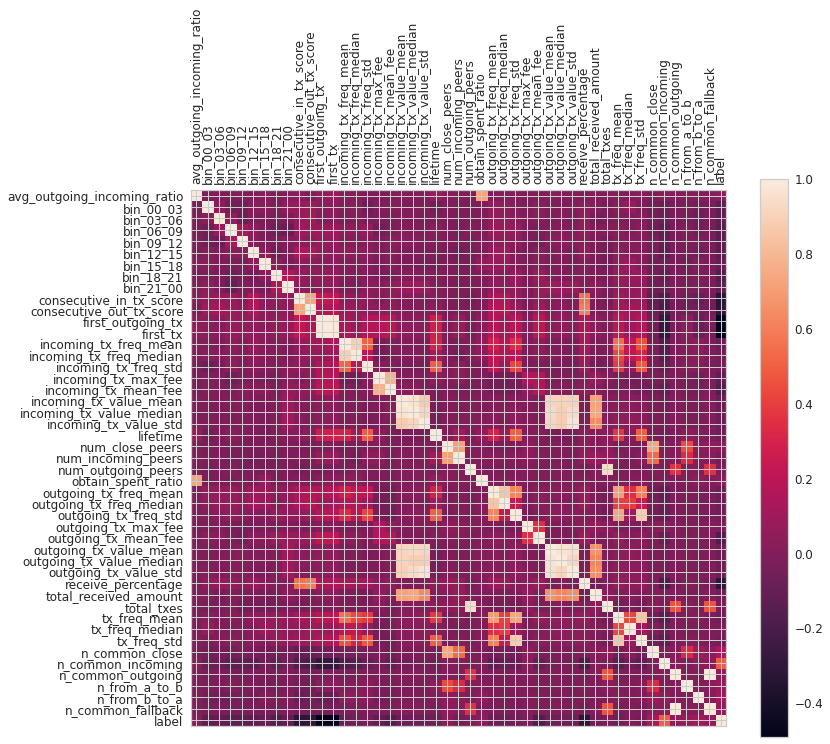

In [4]:
# Lets use a correlation matrix to gain some insight regarding correlation to label:
f = plt.figure(figsize=(12, 10))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

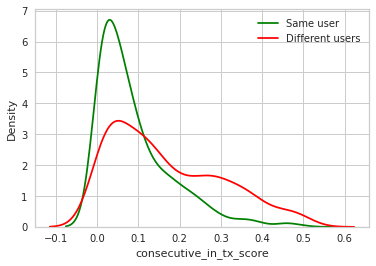

In [5]:
# Let's explore:
sns.kdeplot(data['consecutive_in_tx_score'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['consecutive_in_tx_score'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

In [6]:
# Create a dummy variable:
data['inTxScoreLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['consecutive_in_tx_score'].values]

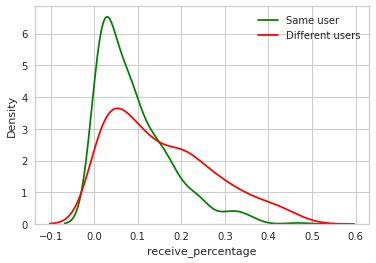

In [7]:
sns.kdeplot(data['receive_percentage'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['receive_percentage'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

In [8]:
# Create a dummy variable:
data['receivePcntLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['receive_percentage'].values]

In [9]:
data.pivot_table(index='n_common_incoming',values='label')

,label
n_common_incoming,
0.0,0.258394
1.0,0.978261
2.0,0.928571
3.0,0.931034
4.0,0.913043
5.0,0.750000
6.0,1.000000
7.0,1.000000
11.0,1.000000


In [10]:
# Create a dummy variable - even 1 in n_common_inc is good:
data['hasCommonInc'] = [1 if 1 <= x  else 0 for x in data['n_common_incoming'].values]

In [11]:
data.pivot_table(index='n_common_close',values='label')

,label
n_common_close,
0.0,0.500951
1.0,1.000000
2.0,1.000000
3.0,1.000000
10.0,1.000000


In [12]:
# Im considering dropping this column - it's too strong and might confuse the model.
# data['hasCommonClose'] = [1 if 1 <= x  else 0 for x in data['n_common_close'].values]
data.drop('n_common_close',axis=1,inplace=True)

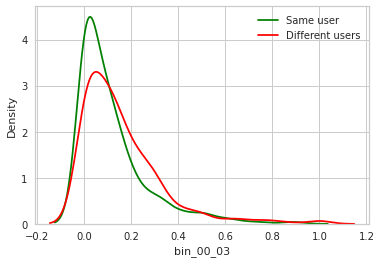

In [13]:
# Checking Bins:
sns.kdeplot(data['bin_00_03'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['bin_00_03'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

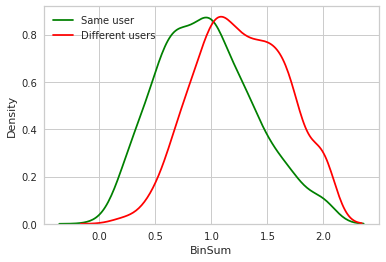

In [14]:
# Let's try sum over all bins:
data['BinSum'] = data['bin_00_03'] + data['bin_03_06'] + data['bin_06_09'] + data['bin_09_12'] + data['bin_12_15'] + data['bin_15_18'] + data['bin_18_21'] + data['bin_21_00']
sns.kdeplot(data['BinSum'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['BinSum'][data['label'].eq(0)],color='red',label='Different users')
plt.legend()

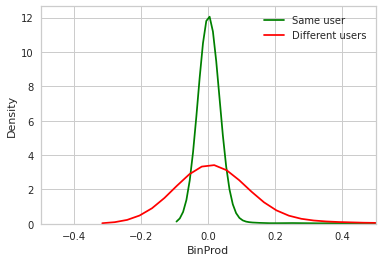

In [15]:
# Seems Nice! Maybe bin product?
data['BinProd'] = data['bin_00_03'] * data['bin_03_06'] * data['bin_06_09'] * data['bin_09_12'] * data['bin_12_15'] * data['bin_15_18'] * data['bin_18_21'] * data['bin_21_00'] * 10**6
sns.kdeplot(data['BinProd'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['BinProd'][data['label'].eq(0)],color='red',label='Different users')
plt.xlim(-0.5,0.5)
plt.legend()

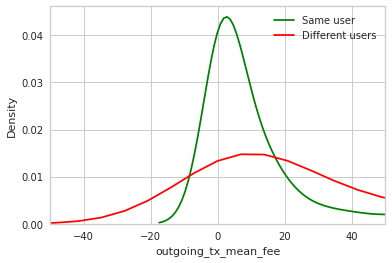

In [16]:
# Fee:
sns.kdeplot(data['outgoing_tx_mean_fee'][data['label'].eq(1)],color='green',label='Same user')
sns.kdeplot(data['outgoing_tx_mean_fee'][data['label'].eq(0)],color='red',label='Different users')
plt.xlim(-50,50)
plt.legend()

# **PCA**

In [17]:
# Lets use PCA to check how well can we explain the data so far:

In [18]:
def prepare_for_pca(data): 
  numData = data.select_dtypes(include='number')
  numData.dropna(inplace=True)
  if 'Survived' in data.columns:
    Colors = numData['Survived']
    numData.drop('Survived',axis=1,inplace=True)
  if 'label' in data.columns:
    Colors = numData['label']
    numData.drop('label',axis=1,inplace=True)
  return numData, Colors

def make_pca_df(numData, ndim=2, scale=True):
  if scale:
    numData = MinMaxScaler().fit_transform(numData)
  pca = PCA(n_components=ndim)
  pc = pca.fit_transform(numData)
  pc_df = pd.DataFrame(data=pc, columns=[f"PC{n+1}" for n in range(ndim)]) 
  print('\n\nExplained variance via PCA:')             
  print(pca.explained_variance_ratio_,'\n\n\n')
  return pc_df

def make_pca_plot(data,title,ndim,scale=True):
  numData, Colors = prepare_for_pca(data)
  pc_df = make_pca_df(numData,ndim,scale)
  if 'bin_00_03' in numData.columns:
    plt.scatter(pc_df['PC1'], pc_df['PC2'], s=3, c=['b' if x == 1 else 'r' for x in Colors.values],label='Same user')
  else:
    plt.scatter(pc_df['PC1'], pc_df['PC2'], s=3, c=['b' if x == 1 else 'r' for x in Colors.values],label='Drowned')
  plt.title(f'PCA Plot - {title}')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.legend()
  plt.show()



Explained variance via PCA:
[0.32292354 0.16473356 0.12587667 0.06482331 0.04575584] 





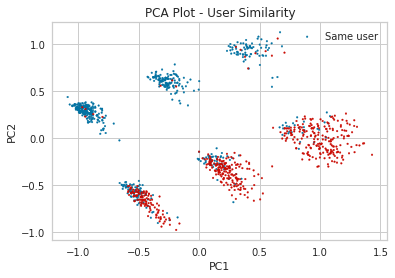

In [19]:
make_pca_plot(data,"User Similarity",ndim=5,scale=True)

In [79]:
def preprocess_ethereum_data(data, scale=True):
  data.drop('Unnamed: 0',axis=1,inplace=True)
  data['inTxScoreLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['consecutive_in_tx_score'].values]
  data['receivePcntLow'] = [1 if 0 <= x <= 0.1 else 0 for x in data['receive_percentage'].values]
  data['hasCommonInc'] = [1 if 1 <= x  else 0 for x in data['n_common_incoming'].values]
  data['hasCommonClose'] = [1 if 1 <= x  else 0 for x in data['n_common_close'].values]
  data.drop('n_common_close',axis=1,inplace=True)
  data['BinSum'] = data['bin_00_03'] + data['bin_03_06'] + data['bin_06_09'] + data['bin_09_12'] + data['bin_12_15'] + data['bin_15_18'] + data['bin_18_21'] + data['bin_21_00']
  data['BinProd'] = data['bin_00_03'] * data['bin_03_06'] * data['bin_06_09'] * data['bin_09_12'] * data['bin_12_15'] * data['bin_15_18'] * data['bin_18_21'] * data['bin_21_00'] * 10**6
  X, Y = data.drop('label',axis=1), data['label']
  if scale:
    X = MinMaxScaler().fit_transform(X)
  return X, Y

# **Model Training and Evaluation**

In [80]:
# Lets fit a classifier.
# Our validation set will be distanceMatrix_test
data = pd.read_csv('distanceMatrix.csv')
print(data.shape)
validation = pd.read_csv('distanceMatrix_test.csv')
for_pca = pd.read_csv('distanceMatrix_test.csv')
print(validation.shape,'\n')
print('Validtion label counts:')
validation.label.value_counts()

(1106, 48)
(1125, 48) 

Validtion label counts:


0    890
1    235
Name: label, dtype: int64

In [81]:
X,Y = preprocess_ethereum_data(data)
X_validation, Y_validation = preprocess_ethereum_data(validation)



Explained variance via PCA:
[0.30895007 0.11826472 0.11036035 0.07635066 0.04752052] 





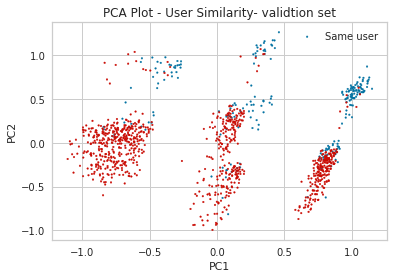

In [82]:
for_pca_x, y = preprocess_ethereum_data(for_pca, scale=False)
for_pca_x['label'] = y
make_pca_plot(validation,"User Similarity- validtion set",ndim=5,scale=True)



Logistic Regression Classification Report 
 with accuracy 0.875


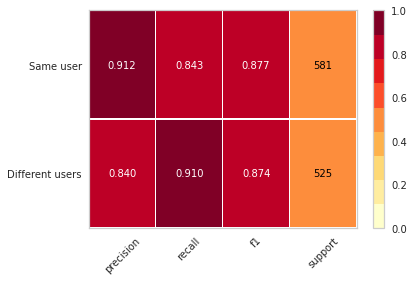

In [83]:
# Train
log_clf = LogisticRegression(random_state=5).fit(X, Y)
p = log_clf.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(log_clf,
                            classes=["Same user","Different users"],
                            support=True)
vis.score(X, Y)
print(f"\n\nLogistic Regression Classification Report \n with accuracy {round(acc,3)}")

In [84]:
pred = log_clf.predict(X_validation)
acc_score = accuracy_score(Y_validation, pred)
f = f1_score(Y_validation, pred)
print("Logitic Regression results on validation set:")
print("Accuracy: ", round(acc_score,3))
print("F1: ", round(f,3) )

Logitic Regression results on validation set:
Accuracy:  0.891
F1:  0.763




Logistic Regression CV Classification Report 
 with accuracy 0.893


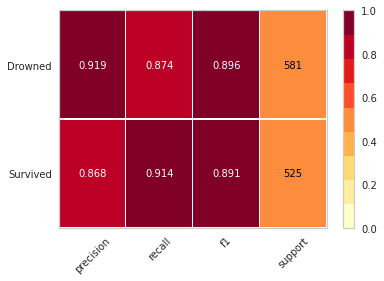

In [85]:
import warnings
warnings.filterwarnings("ignore")

logCV_clf = LogisticRegressionCV(random_state=10678678).fit(X, Y)
p = logCV_clf.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(logCV_clf,
                           max_iter = 1000,
                            classes=["Drowned","Survived"],
                            support=True)
vis.score(X, Y)
print(f"\n\nLogistic Regression CV Classification Report \n with accuracy {round(acc,3)}")

In [86]:
predCV = logCV_clf.predict(X_validation)
acc_score = accuracy_score(Y_validation, predCV)
f = f1_score(Y_validation, predCV)
print("Logitic Regression CV results on validation set:")
print("Accuracy: ", round(acc_score,3))
print("F1: ", round(f,3) )

Logitic Regression CV results on validation set:
Accuracy:  0.894
F1:  0.782


In [64]:
def kfold_cv(X,Y,n_iterations):
  lambdas = np.linspace(0.01,1,100)
  scores = dict()
  for lam in lambdas:
    scores[str(lam)] = []
    for iteration in range(n_iterations):
      X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25)
      tree = xgb.XGBClassifier(n_estimators=5,
                              max_depth=4,
                              objective='reg:squarederror',
                              reg_lambda = lam)
      tree.fit(X_train,Y_train)
      p = tree.predict(X_test)
      f1 = f1_score(Y_test, p)
      scores[str(lam)].append(f1)
  return scores

In [90]:
scores = kfold_cv(X,Y,5)

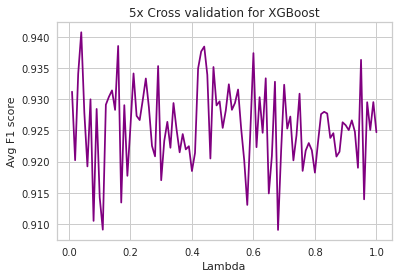

In [91]:
sns.lineplot([float(key) for key in scores.keys()],[np.mean(val) for val in scores.values()],color='purple')
plt.title('5x Cross validation for XGBoost')
plt.ylabel('Avg F1 score')
plt.xlabel('Lambda')
plt.show()

In [92]:
best_lambda = sorted(scores,key=lambda x:np.mean(scores[x]),reverse=True)[0]
print("Best performing Lambda: ", best_lambda)

Best performing Lambda:  0.04




XGBoost Classification Report 
 with accuracy 0.956


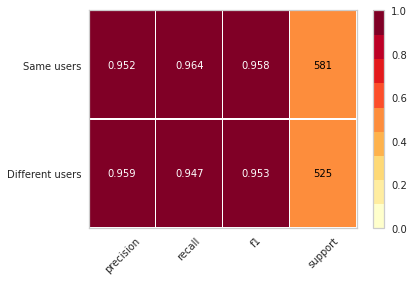

In [93]:
tree = xgb.XGBClassifier(n_estimators=5,
                         max_depth=4,
                         objective='reg:squarederror',
                         reg_lambda = best_lambda)
tree.fit(X,Y)
p = tree.predict(X)
acc = accuracy_score(Y, p)
vis = ClassificationReport(tree,
                           classes=["Same users","Different users"],
                           support=True)
vis.score(X, Y)
print(f"\n\nXGBoost Classification Report \n with accuracy {round(acc,3)}")

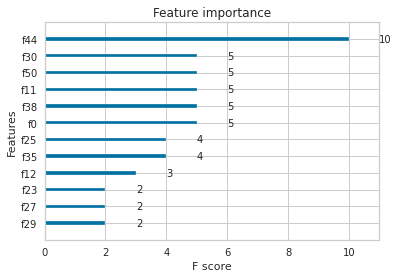

In [94]:
xgb.plot_importance(tree,max_num_features=12)

In [95]:
tree_pred = tree.predict(X_validation)
acc_score = accuracy_score(Y_validation, tree_pred)
f = f1_score(Y_validation, tree_pred)
print("XGBoost Regression results on validation set:")
print("Accuracy: ", round(acc_score,3))
print("F1: ", round(f,3) )

XGBoost Regression results on validation set:
Accuracy:  0.844
F1:  0.723


In [96]:
# Seems like xgboost is overfitting, while logistic regression is doing great.

In [97]:
a,b,c = lars_path(X_validation, Y_validation, method="lasso", verbose=False)

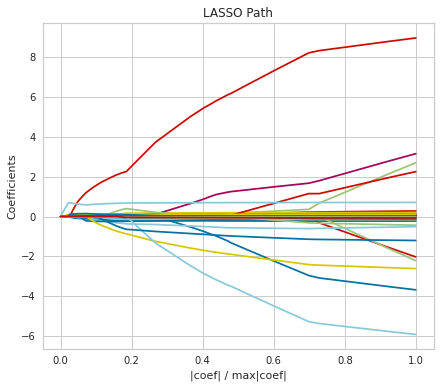

In [98]:
xx = np.sum(np.abs(c.T), axis=1)
xx /= xx[-1]
f = plt.figure(figsize=(7, 6))
plt.plot(xx, c.T)
ymin, ymax = plt.ylim()
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

In [99]:
print("10 Most important features: ")
for feature in b[:10]:
  print(for_pca_x.columns[feature])

10 Most important features: 
hasCommonInc
inTxScoreLow
receivePcntLow
first_tx
receive_percentage
n_common_fallback
consecutive_in_tx_score
incoming_tx_mean_fee
num_outgoing_peers
first_outgoing_tx
